# 1. Duomenų analizė: 

Išanalizuoti duomenis ir pateikti duomenų santrauką: kiek kokių kategorijų drabužių turime? Kiek duomenų yra test validation, training duomenų rinkiniuose? Kiek drabužių yra vaikiškų? Kokio tipo drabužiai dažniausiai yra vaikiški.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import tensorflow_hub as hub
import os

In [2]:
df = pd.read_csv("images.csv")
df['image'] = 'images/' + df['image'] + ".jpg"
df

,image,sender_id,label,kids
0,images/4285fab0-751a-4b74-8e9b-43af05deee22.jpg,124,Not sure,False
1,images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,148,T-Shirt,False
2,images/00627a3f-0477-401c-95eb-92642cbe078d.jpg,94,Not sure,False
3,images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,43,T-Shirt,False
4,images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,189,Shoes,False
...,...,...,...,...
5398,images/dfd4079d-967b-4b3e-8574-fbac11b58103.jpg,204,Shorts,False
5399,images/befa14be-8140-4faf-8061-1039947e329d.jpg,204,Body,True
5400,images/5379356a-40ee-4890-b416-2336a7d84061.jpg,310,Shorts,False
5401,images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg,204,Shoes,False


In [3]:
df['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

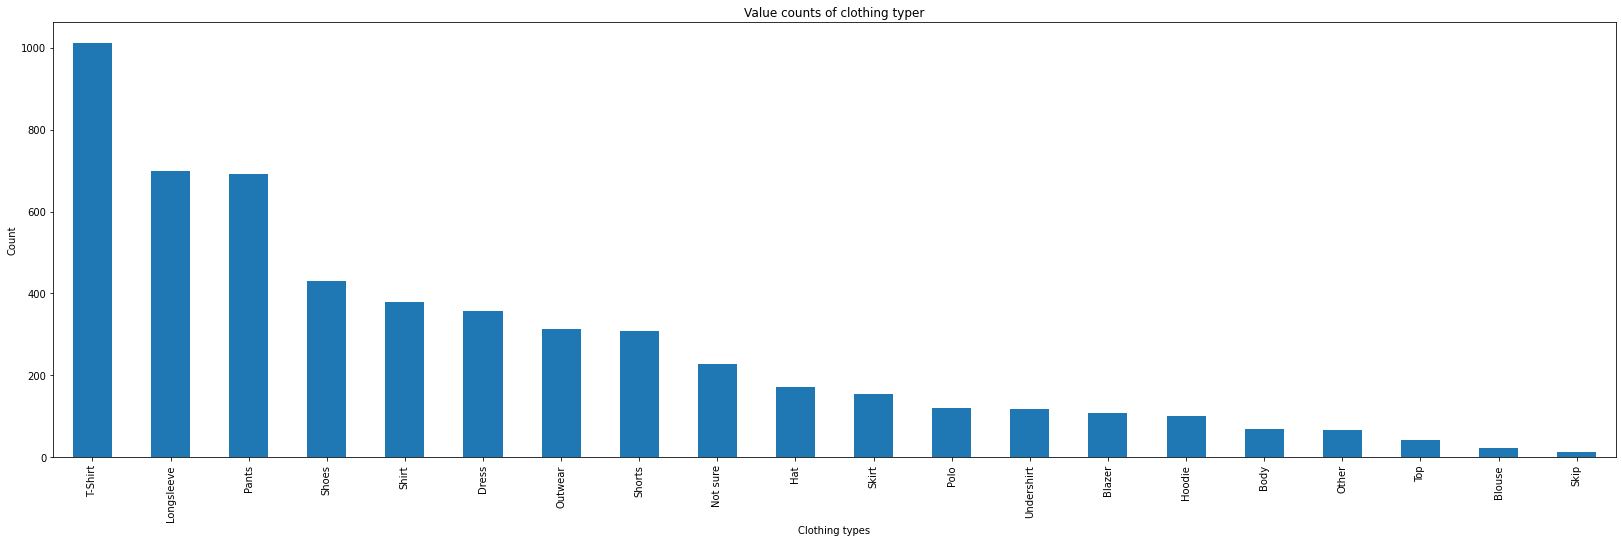

In [4]:
ax = df['label'].value_counts().plot(kind='bar',
figsize=(28,8),
title="Value counts of clothing typer")
ax.set_xlabel("Clothing types")
ax.set_ylabel("Count");

In [5]:
df['kids'].value_counts()

False    4927
True      476
Name: kids, dtype: int64

In [6]:
kids_clothing_percent = len(df[df['kids'] == True]) * 100 / len(df)
print(f"Matome, kad mūsų turimuose duomenyse yra tik {round(kids_clothing_percent, 2)}% vaikiškų rūbų")

Matome, kad mūsų turimuose duomenyse yra tik 8.81% vaikiškų rūbų


In [7]:
df[df['kids'] == True]['label'].value_counts()

Pants         87
Body          68
Shoes         60
Dress         48
Longsleeve    38
Outwear       35
Other         28
T-Shirt       27
Shorts        24
Undershirt    15
Hat           10
Not sure       7
Skirt          7
Shirt          6
Top            5
Polo           5
Hoodie         3
Blazer         2
Skip           1
Name: label, dtype: int64

In [8]:
# Daugiauisiai pasitaikančios vaikiškų rūbų kategorijos yra Pants, Body ir Shoes

In [9]:
# Pasirenkame top 10 kategorijų ir sukuriame train ir test duomenų failus

In [10]:
CLASS_NAMES = ["T-Shirt", "Longsleeve", "Pants", "Shirt", "Dress", "Shorts", "Shoes", "Outwear", "Hat", "Skirt"]
selected_df = df[df['label'].isin(CLASS_NAMES)]
selected_df = selected_df.reset_index(drop=True)
selected_df.drop(['sender_id', 'kids'], axis=1, inplace=True)
train, test = train_test_split(selected_df)
train.to_csv('train.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

In [11]:
print(f"Train ir test failų dydžiai : {len(train), len(test)}")

Train ir test failų dydžiai : (3385, 1129)


# 2. Modelio kūrimas

In [12]:
# Nurodome nuotraukos dydį ir nuotraukos kanalų skaičių
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [13]:
# Funkcija skirta nuskaityti nuotraukos failą ir konvertuoti nuotraukos pikselių vertes į [0,1] ribas, tuomet pakeičiamas nuotraukos dydis į nurodyta aukščiau
def read_and_decode(filename, reshape_dims, resize=True):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if resize:
        img = tf.image.resize(img, reshape_dims)
    return img

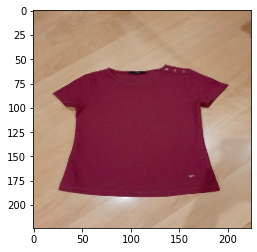

In [14]:
img = read_and_decode(selected_df['image'][0], [IMG_HEIGHT, IMG_WIDTH])
plt.imshow(img)

In [15]:
# Funckcija nuskaito .csv failą ir grąžina apdorotą nuotrauką ir rūbo kategoriją
def decode_csv(csv_row):
    record_defaults = ["path", "class"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [16]:
# Funckija paruošia train ir test datasetus
def prep_datasets(train_file, test_file, batch_size = 16):
    train_dataset = (tf.data.TextLineDataset(
        train_file).map(decode_csv)).batch(batch_size)
    
    eval_dataset = (tf.data.TextLineDataset(
        test_file).map(decode_csv)).batch(batch_size)
    
    return train_dataset, eval_dataset

In [19]:
train_dataset, eval_dataset = prep_datasets("train.csv", "test.csv")

In [23]:
# Bandome paprastą tiesinį modelį

In [24]:
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 10)                1505290   
                                                                 
Total params: 1,505,290
Trainable params: 1,505,290
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=20)

Epoch 1/20
212/212 [==============================] - 5s 23ms/step - loss: 27.5735 - accuracy: 0.2490 - val_loss: 15.8948 - val_accuracy: 0.2436
Epoch 2/20
212/212 [==============================] - 4s 19ms/step - loss: 18.2825 - accuracy: 0.3013 - val_loss: 17.8070 - val_accuracy: 0.2923
Epoch 3/20
212/212 [==============================] - 4s 20ms/step - loss: 15.8032 - accuracy: 0.3371 - val_loss: 27.7458 - val_accuracy: 0.2356
Epoch 4/20
212/212 [==============================] - 4s 19ms/step - loss: 18.5185 - accuracy: 0.3651 - val_loss: 17.7341 - val_accuracy: 0.4446
Epoch 5/20
212/212 [==============================] - 4s 19ms/step - loss: 15.4567 - accuracy: 0.3867 - val_loss: 20.2837 - val_accuracy: 0.2569
Epoch 6/20
212/212 [==============================] - 4s 19ms/step - loss: 14.3324 - accuracy: 0.4148 - val_loss: 19.4402 - val_accuracy: 0.2453
Epoch 7/20
212/212 [==============================] - 4s 19ms/step - loss: 14.7715 - accuracy: 0.4000 - val_loss: 23.4026 - val_ac

# Atvaizduojame modelio treniravimo rezultatus

In [27]:
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

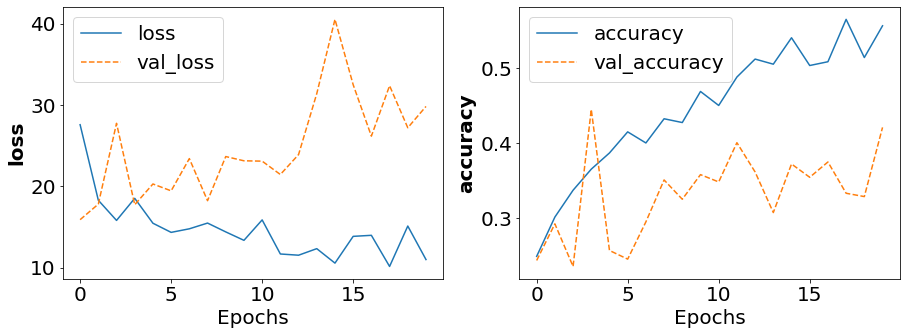

In [28]:
training_plot(['loss', 'accuracy'], history);

In [57]:
# Matome, kad modelio tikslumas yra labai nestabilus, didžiausias pasiektas tikslumas - 44%, kas yra prastas rezultatas. Galima bandyti didinti epochų skaičių, kadangi modelis dar nėra overtrainintas, bet tikslumas žymiai nepadidėtų.

In [30]:
# Atvaizduojame modelio spejimus

In [31]:
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(40,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

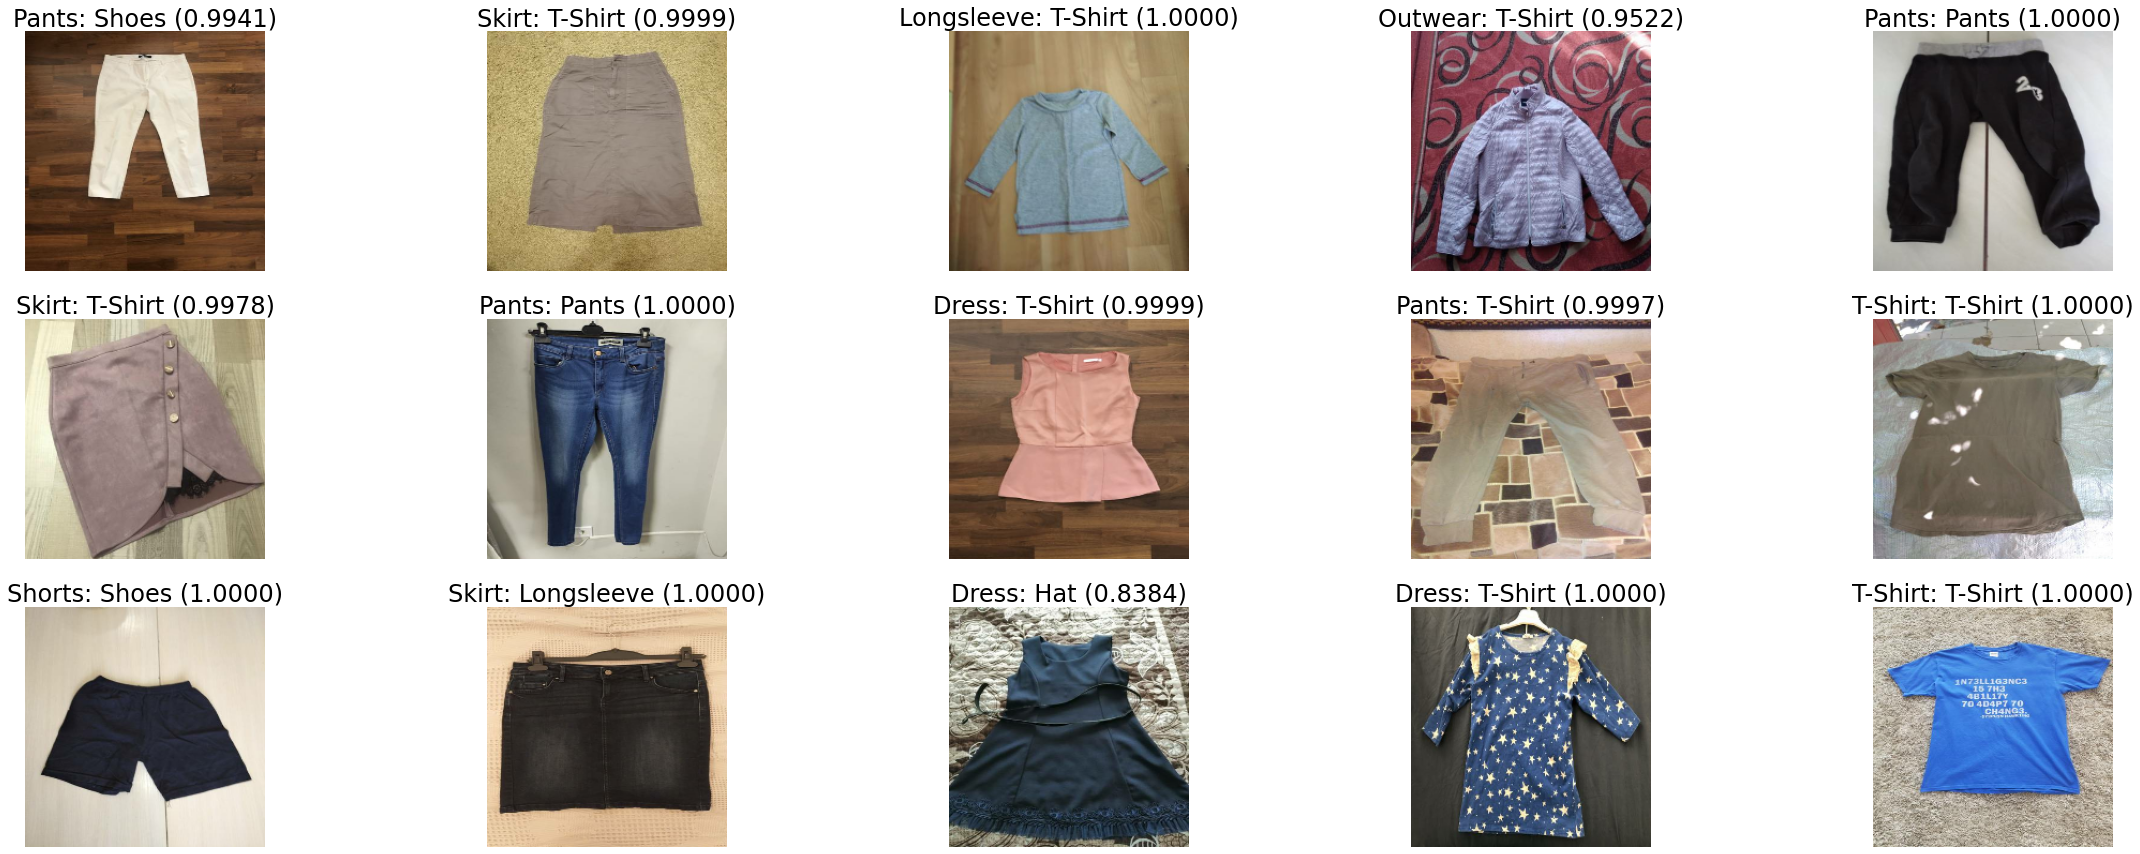

In [32]:
plot_predictions(model, 'test.csv')

In [33]:
# Šiame modelyje pridedame dar viena paslėptą Dense sluoksnį

In [71]:
train_dataset, eval_dataset = prep_datasets("train.csv", "test.csv", 32)                
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
99/99 [==============================] - 4s 38ms/step - loss: 6.4478 - accuracy: 0.1656 - val_loss: 2.0682 - val_accuracy: 0.1662
Epoch 2/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0592 - accuracy: 0.2213 - val_loss: 2.0521 - val_accuracy: 0.2283
Epoch 3/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0433 - accuracy: 0.2458 - val_loss: 2.0381 - val_accuracy: 0.2283
Epoch 4/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0299 - accuracy: 0.2458 - val_loss: 2.0267 - val_accuracy: 0.2283
Epoch 5/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0190 - accuracy: 0.2458 - val_loss: 2.0176 - val_accuracy: 0.2283
Epoch 6/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0103 - accuracy: 0.2458 - val_loss: 2.0106 - val_accuracy: 0.2283
Epoch 7/10
99/99 [==============================] - 4s 37ms/step - loss: 2.0035 - accuracy: 0.2458 - val_loss: 2.0052 - val_accuracy: 0.2283
Epoch 8/10
99

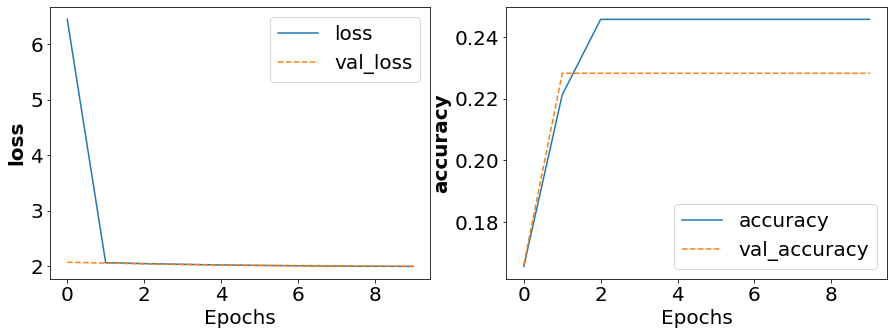

In [72]:
training_plot(['loss', 'accuracy'], history)

In [73]:
# Matome, kad pridėjus dar vieną sluoksnį gauname dar prastesnį modelį, kurio tikslumas siekia ~23% ir modelis nuo pirmos epochos visiškai "nebesimoko". Toliau atliksime modelio parametrų optimizavimą

In [77]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 128,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0.01,
                       num_hidden = 256):

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset, eval_dataset = prep_datasets("train.csv", "test.csv", batch_size)

  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=20)
  training_plot(['loss', 'accuracy'], history)
  return model

In [78]:
# (batch_size = 12,
#     lrate = 0.001, # default in Adam constructor
#     l1 = 0,
#     l2 = 0,
#     num_hidden = 128): # 0.2259 %
    
# (batch_size = 128,
#    lrate = 0.001, # default in Adam constructor
#    l1 = 0,
#    l2 = 0,
#    num_hidden = 128): # 0.3198 %

Epoch 1/20
25/25 [==============================] - 12s 456ms/step - loss: 107.0656 - accuracy: 0.1636 - val_loss: 52.9896 - val_accuracy: 0.2302
Epoch 2/20
25/25 [==============================] - 11s 445ms/step - loss: 28.8506 - accuracy: 0.2209 - val_loss: 19.8389 - val_accuracy: 0.4107
Epoch 3/20
25/25 [==============================] - 11s 445ms/step - loss: 15.7691 - accuracy: 0.3152 - val_loss: 11.5275 - val_accuracy: 0.3343
Epoch 4/20
25/25 [==============================] - 11s 445ms/step - loss: 14.0222 - accuracy: 0.2954 - val_loss: 13.4284 - val_accuracy: 0.3123
Epoch 5/20
25/25 [==============================] - 11s 443ms/step - loss: 14.7763 - accuracy: 0.2958 - val_loss: 14.2221 - val_accuracy: 0.3372
Epoch 6/20
25/25 [==============================] - 11s 444ms/step - loss: 11.1421 - accuracy: 0.3219 - val_loss: 9.3788 - val_accuracy: 0.4145
Epoch 7/20
25/25 [==============================] - 11s 444ms/step - loss: 7.4918 - accuracy: 0.3964 - val_loss: 7.1397 - val_accu

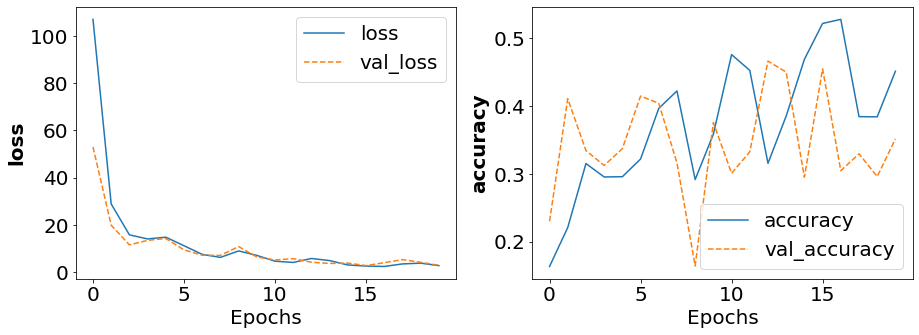

In [79]:
model = train_and_evaluate()

In [81]:
# Matome, kad modelis yra labai nestabilus ir modelio tikslumas nedidėja, didžiausias gautas tikslumas ~47%, nežymiai geresnis nei tiesinis modelis. Taikysime jau apmokytą modelį, kuris apmokytas su dideliu duomenų kiekiu.

# Pritaikome jau apmokytą MobileNet modelį

In [59]:
# Skirtingų metrikų bandymai :

In [60]:
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.,
#                        dropout_prob = 0.1,
#                        num_hidden = 32) # 0.8539
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.2,
#                        dropout_prob = 0.1,
#                        num_hidden = 32) # 0.7104
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.1,
#                        dropout_prob = 0.1,
#                        num_hidden = 32) # 0.7989
# (batch_size = 16,
#                        lrate = 0.005,
#                        l1 = 0.,
#                        l2 = 0.,
#                        dropout_prob = 0.1,
#                        num_hidden = 32) # 0.8441 
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.,
#                        dropout_prob = 0.1,
#                        num_hidden = 64) # 0.8335
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.,
#                        dropout_prob = 0.1,
#                        num_hidden = 16) # 0.8450
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.,
#                        dropout_prob = 0.2,
#                        num_hidden = 32) # 0.8477
# (batch_size = 16,
#                        lrate = 0.001,
#                        l1 = 0.,
#                        l2 = 0.001,
#                        dropout_prob = 0.1,
#                        num_hidden = 32) # 0.8397

In [58]:
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 16,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       dropout_prob = 0.1,
                       num_hidden = 32): 
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset, eval_dataset = prep_datasets("train.csv", "test.csv", batch_size)

  layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='clothe_prob')
  ]

  model = tf.keras.Sequential(layers, name='clothing_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "clothing_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 clothe_prob (Dense)         (None, 10)                330       
                                                                 
Total params: 2,299,306
Trainable params: 41,322
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
212/212 [==============================] - 49s 224ms/step - loss: 0.8266 - accuracy: 0.7226 - val_loss: 0.4993 - val_accuracy: 0.8202
Epoch 2/10
212/212 [==============================] - 46s 219ms/step - loss:

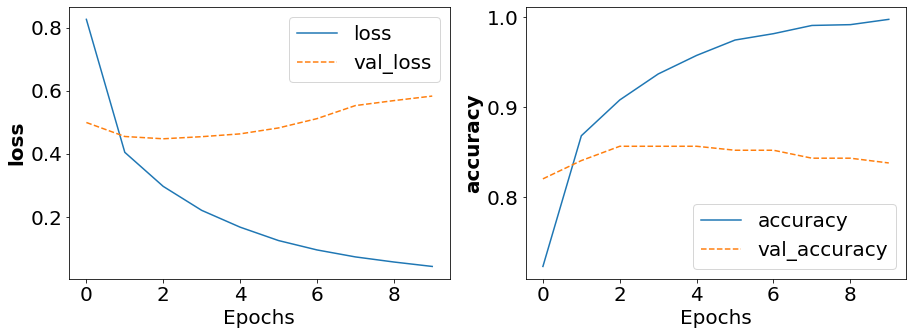

In [56]:
model = train_and_evaluate()

In [68]:
# Su apmokytų modeliu gauname žymiai geresnius rezultatus - 84-86% tikslumas. Dvigubai geresni rezultatai nei bandant paprastesnius modelius su nedideliu, lyginant su apmokytu modeliu, duomenų kiekiu. 
# Modelis beveik overtrainintas, tad padidint tikslumą yra ganėtinai sunku.

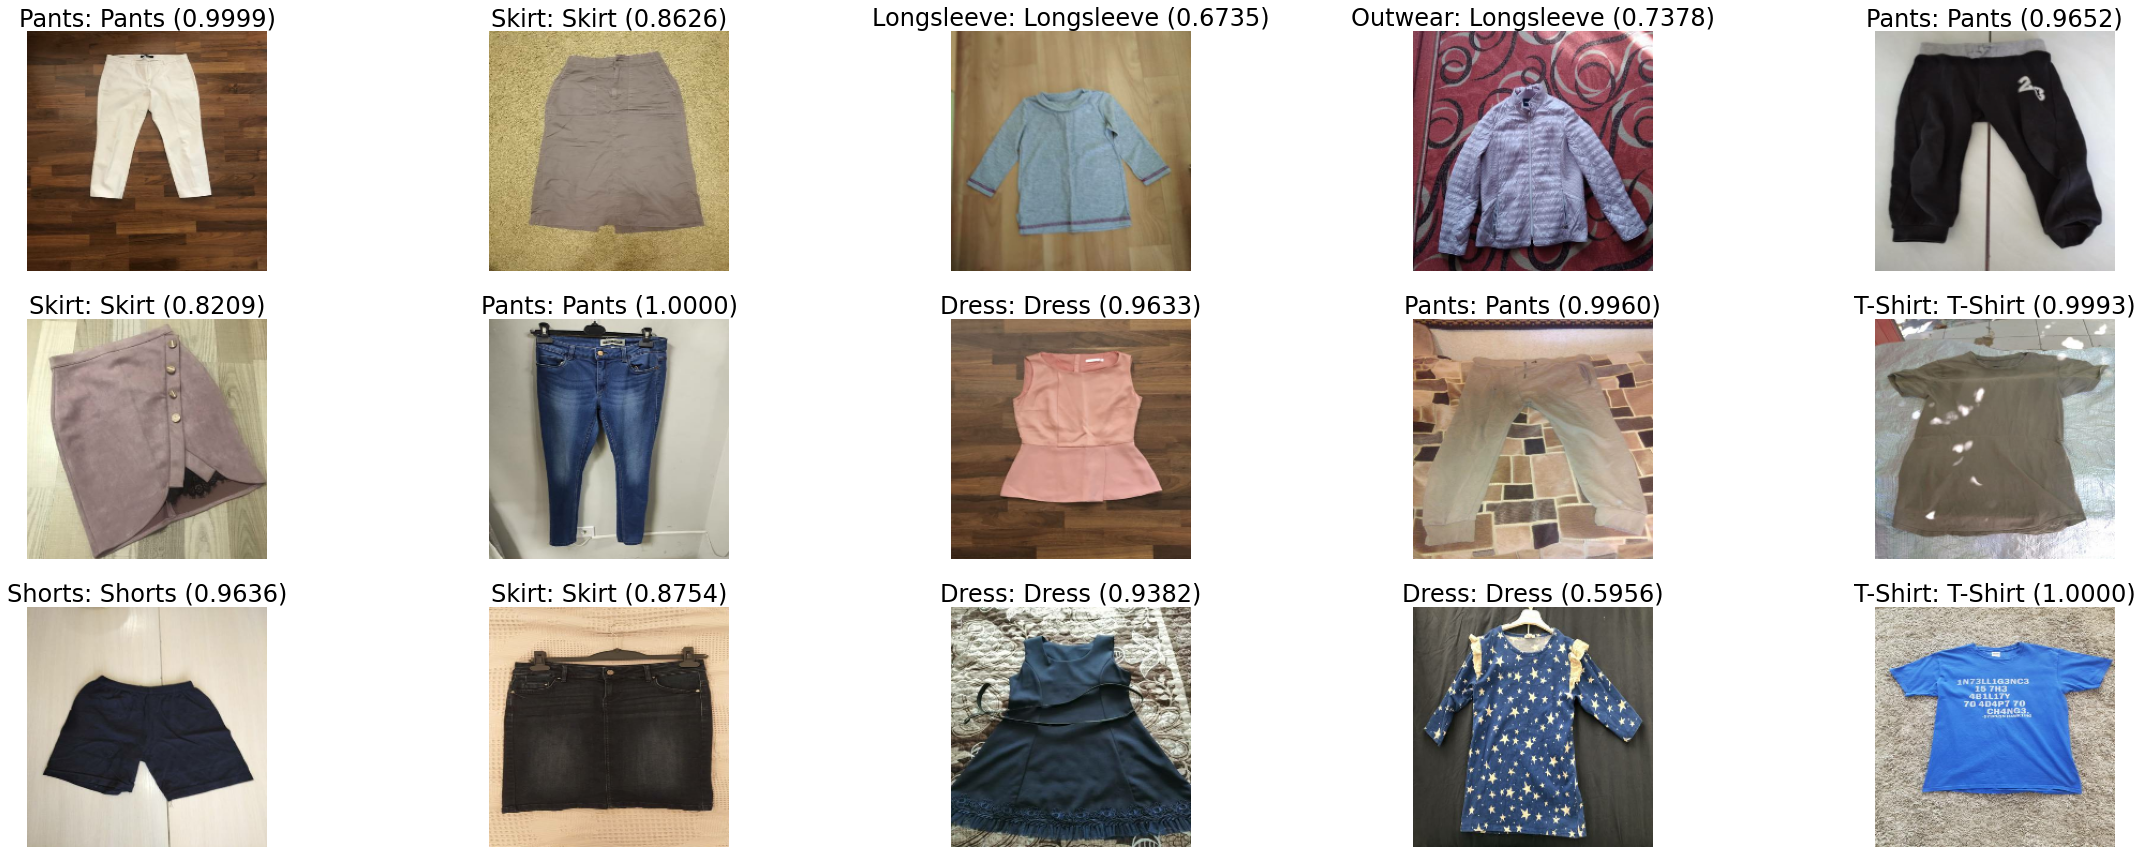

In [61]:
plot_predictions(model, "test.csv")

In [82]:
# Issaugome modeli

In [63]:
model.save('ClothingPredictionModel')

INFO:tensorflow:Assets written to: ClothingPredictionModel\assets


INFO:tensorflow:Assets written to: ClothingPredictionModel\assets


In [64]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir ClothingPredictionModel

The given SavedModel SignatureDef contains the following input(s):
  inputs['mobilenet_embedding_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_mobilenet_embedding_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['clothe_prob'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2022-05-14 20:07:14.523702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-14 20:07:14.523730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
